In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns

import gcsfs

import itertools

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 


In [2]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
def pretty_pair_plot(df):
    g = sns.PairGrid(df)
    g.map_upper(sns.kdeplot)
    g.map_diag(sns.histplot)
    g.map_upper(corrfunc)
    g.map_lower(sns.scatterplot)
    return g

Read in data

In [12]:
gcs_path = 'gs://smart4'

count_data = pd.read_csv(f'{gcs_path}/count_file/Final_data_March5.csv')

segment_geos =gpd.read_file('../Revised_Estimated_SC_ATT_march1.geojson')
#= gpd.read_file(f'{gcs_path}/count_file/Revised_Estimated_SC_ATT_march1.geojson')

#places = gpd.read_file(f'{gcs_path}/context_data/census/tl_2021_06_place')

#counties = gpd.read_file(f'{gcs_path}/context_data/census/tl_2021_us_county')
#counties = counties.query("STATEFP == '06'")

In [15]:
# join the geometries to the attributes
count_data = count_data.join(segment_geos.set_index(['matched_seg_id', 'Leg', 'year'])[['geometry']],
                on=['matched_seg_id', 'Leg', 'year'])

count_data = count_data.drop(columns=['Unnamed: 0'])

In [16]:
count_data = gpd.GeoDataFrame(count_data)

In [17]:
count_data.duplicated(subset=['matched_seg_id', 'Leg', 'year']).sum()

0

In [ ]:
# Join the place and county names to the segments for increased legibility
places = places.to_crs(count_data.crs)
counties = counties.to_crs(count_data.crs)

# Traffic data exploration
Let's start with an exploration of our imputed bike traffic volumes. First I'm going to switch this to a more standard AADT.

In [18]:
count_data['aadt'] = count_data['ATT']/365.

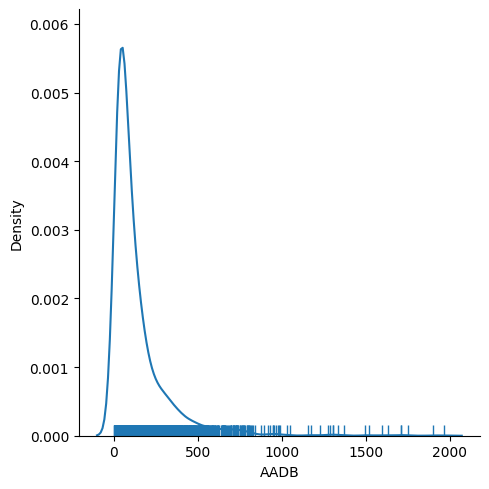

In [20]:
sns.displot(count_data['AADB'], kind='kde', rug=True)

In [21]:
count_data.sort_values('AADB', ascending=False)[['year', 'tdg_id', 'AADB', 'street_name', 'county']].head(20)

year  tdg_id  AADB              street_name           county
720   2016  135719  1967               5th Street             Yolo
723   2016  135725  1900               5th Street             Yolo
724   2016  135733  1749               5th Street             Yolo
721   2016  135719  1706               5th Street             Yolo
725   2016  135733  1706               5th Street             Yolo
722   2016  135725  1631               5th Street             Yolo
718   2016  135715  1594               5th Street             Yolo
717   2016  135705  1516               5th Street             Yolo
719   2016  135715  1494               5th Street             Yolo
1643  2016  135700  1372               5th Street             Yolo
594   2016  108467  1332  North Santa Rosa Street  San Luis Obispo
716   2016  135702  1306               5th Street             Yolo
714   2016  135694  1306               5th Street             Yolo
593   2016  107899  1287       Foothill Boulevard  San Luis Obispo
715   2016  135702  1273               5th Street             Yolo
1782  2017   24120  1225         Franciscan Plaza             Kern
1642  2016  135683  1173               5th Street             Yolo
726   2016  135749  1154        Russell Boulevard             Yolo
383   2015   27751  1049     North Chester Avenue             Kern
1346  2016  117817  1032              King Street       Santa Cruz

In [28]:
with pd.option_context('display.max_columns', 300):
    print(count_data.head())

   X  index  year Leg  matched_seg_id        Lat        Long     ATT  \
0  0      0  2014   E            6191  37.916293 -122.026658  124231   
1  1      1  2014   E            6234  37.885158 -122.077300   17640   
2  2      2  2014   E           49197  34.049795 -117.815552   11809   
3  3      3  2014   E           49209  34.043425 -117.846269   13160   
4  4      4  2014   E           53084  34.036725 -118.268227  145406   

   ATT.in.Million  AADB  segment_id        street_name        county  tdg_id  \
0        0.124231   340    155492.0      Walnut Avenue  Contra Costa    6191   
1        0.017640    48         NaN  Olympic Boulevard  Contra Costa    6234   
2        0.011809    32    127847.0      Temple Avenue   Los Angeles   49197   
3        0.013160    36    127862.0      Temple Avenue   Los Angeles   49209   
4        0.145406   398    129431.0   Venice Boulevard   Los Angeles   53084   

   lrs_cal_id  bikes_proh  bike_facs  int_tdg_id  loc_id seg_counter  \
0           0 

# Strava columns
Next, we'll look into all the Strava columns.

In [31]:
strava_column_templates = [
    '{direction}_trip_count',
    '{direction}_commute_trip_count',
    '{direction}_leisure_trip_count',
    '{direction}_average_speed']

directions = ['forward', 'reverse']

strava_col_params = [{'direction': q[0]} for q in itertools.product(directions)]

strava_cols = []
for template in strava_column_templates:
    for params in strava_col_params:
        strava_cols.append(template.format(**params))

In [32]:
strava_cols

['forward_trip_count',
 'reverse_trip_count',
 'forward_commute_trip_count',
 'reverse_commute_trip_count',
 'forward_leisure_trip_count',
 'reverse_leisure_trip_count',
 'forward_average_speed',
 'reverse_average_speed']

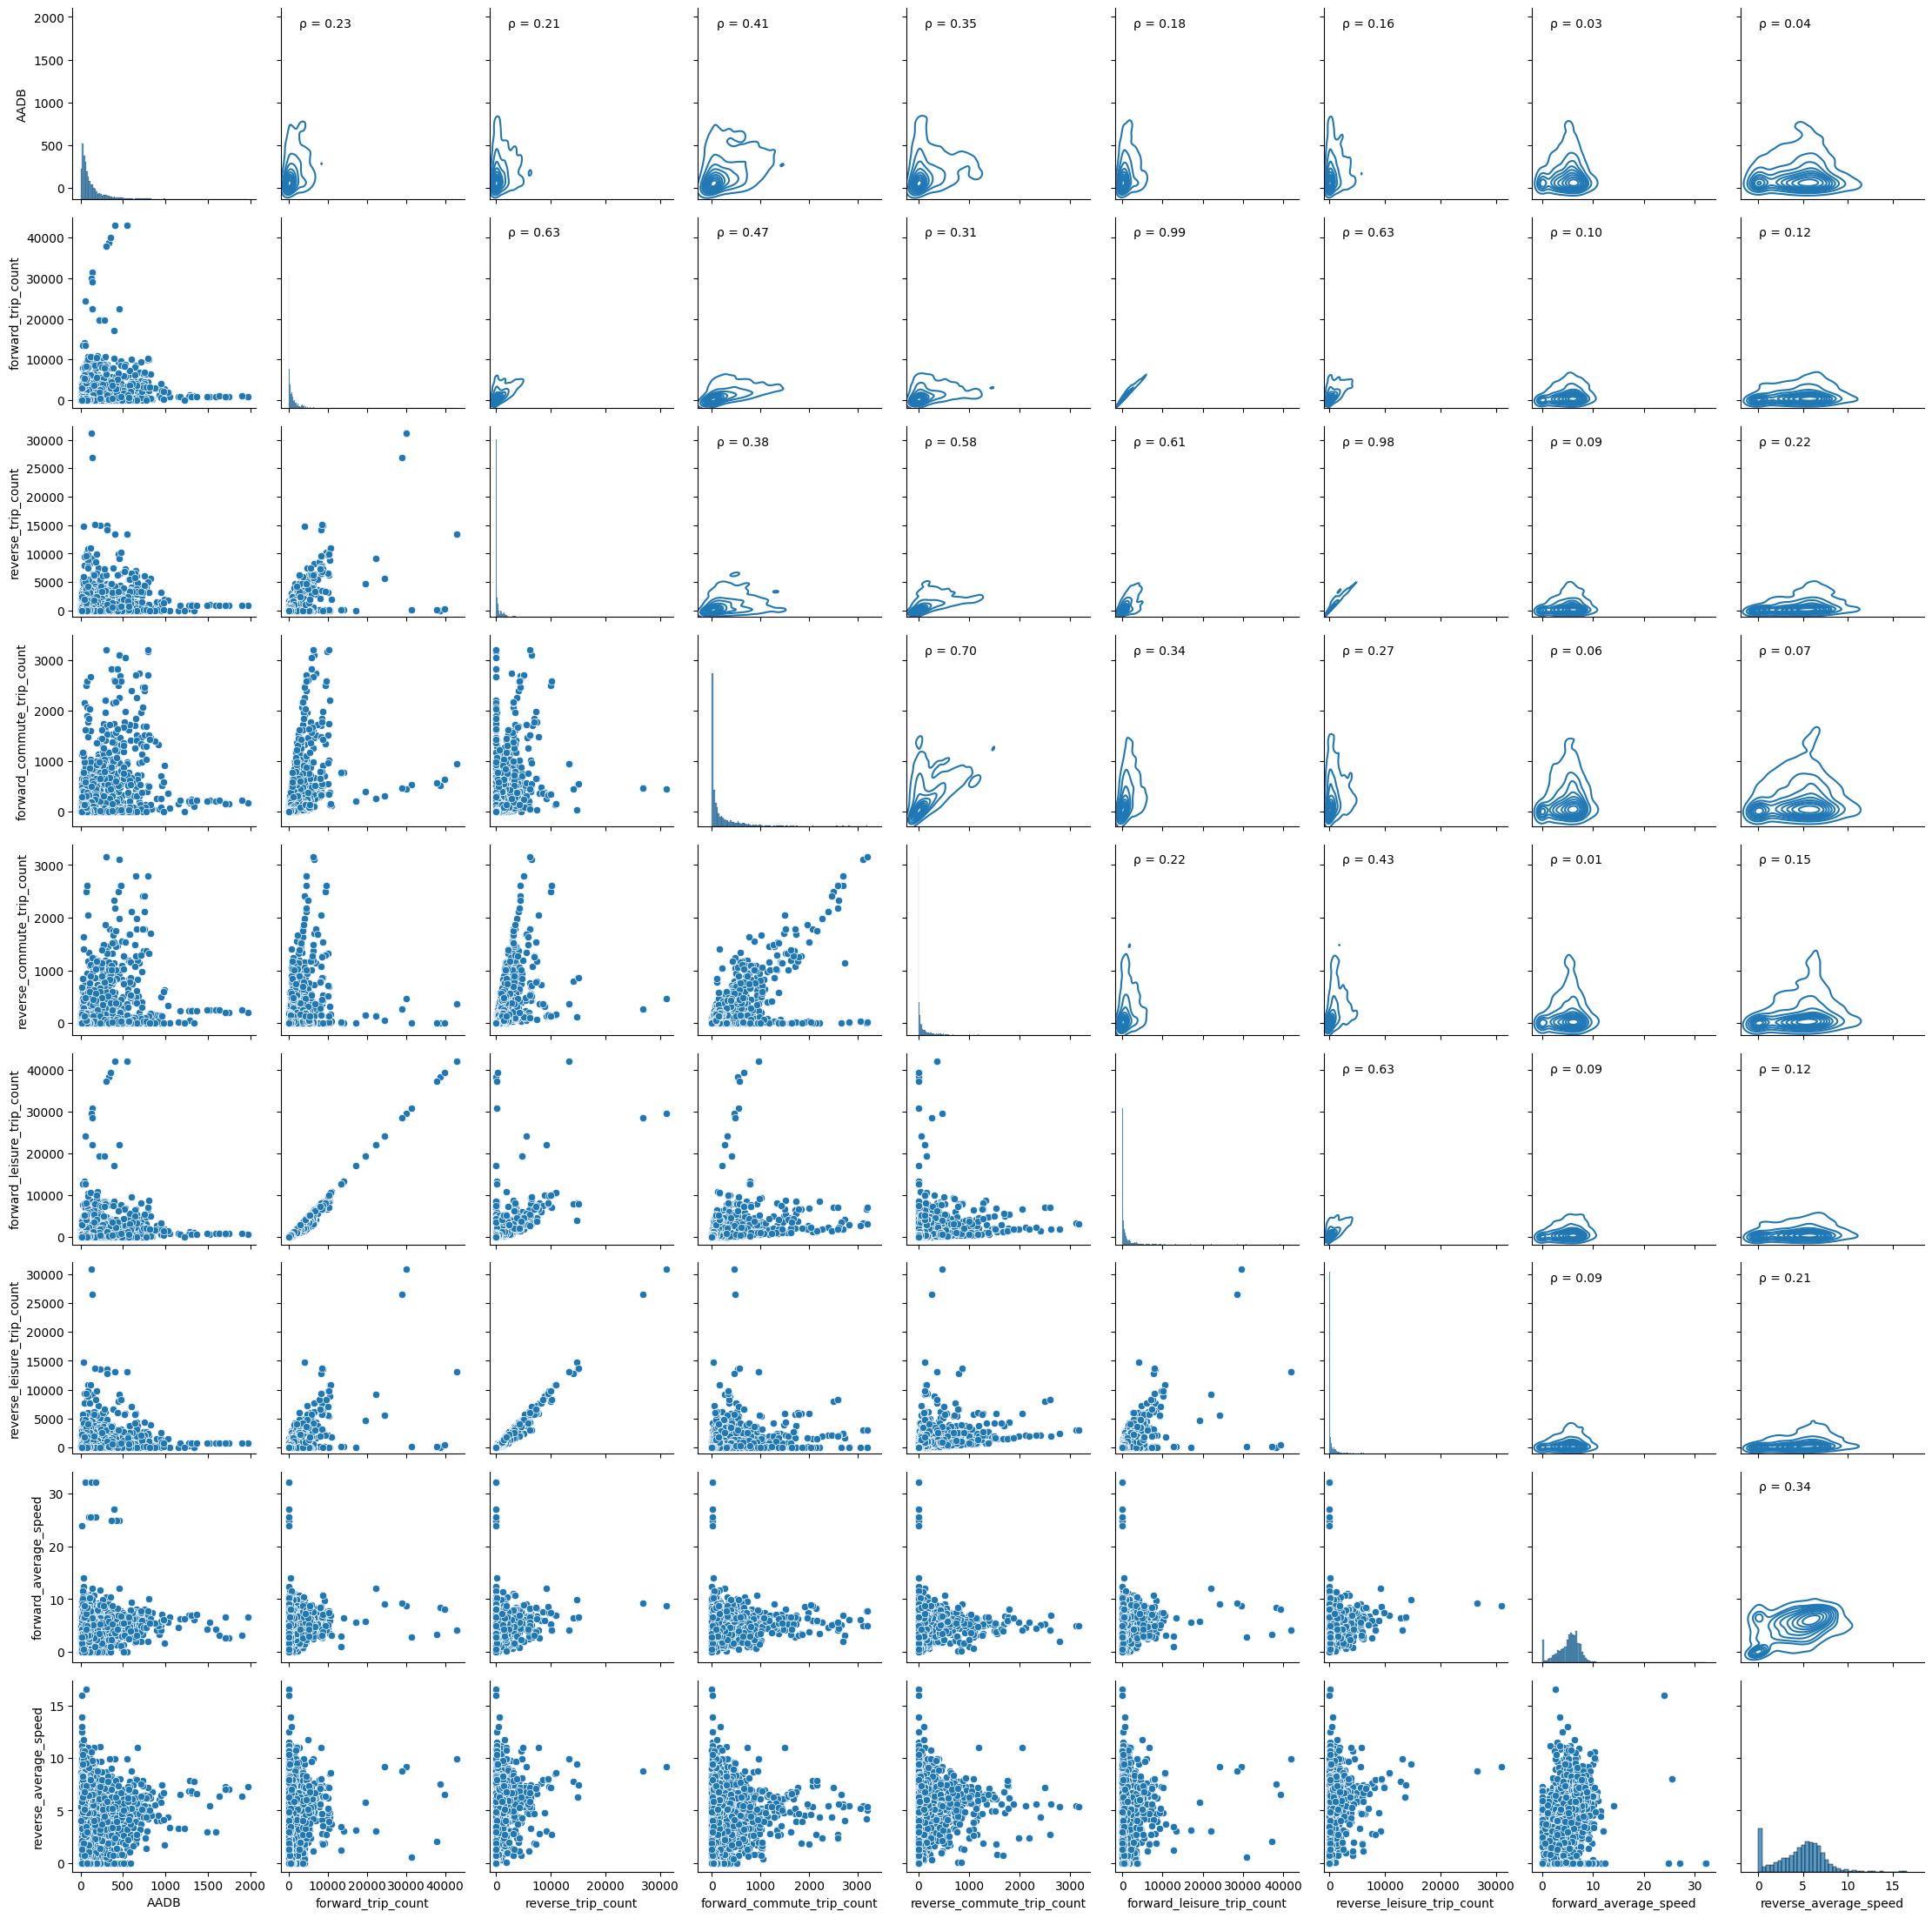

In [35]:
pretty_pair_plot(count_data[['AADB'] + strava_cols])

In [39]:
count_data.sort_values('forward_commute_trip_count', ascending=False)[['street_name', 'county', 'forward_commute_trip_count', 'AADB']]

street_name       county  forward_commute_trip_count  AADB
2730      Horton Street      Alameda                      3205.0   305
1506   Venice Boulevard  Los Angeles                      3205.0   796
551    Venice Boulevard  Los Angeles                      3175.0   790
1219      Horton Street      Alameda                      3107.5   450
2703    Mandela Parkway      Alameda                      3055.0   526
...                 ...          ...                         ...   ...
2140        18th Avenue         Kern                         0.0   330
3160  West Cecil Avenue         Kern                         0.0    24
3161       Summer Drive         Kern                         0.0    54
3162    Lockwood Avenue         Kern                         0.0    39
1242         Park Drive         Kern                         0.0   614

[3578 rows x 4 columns]

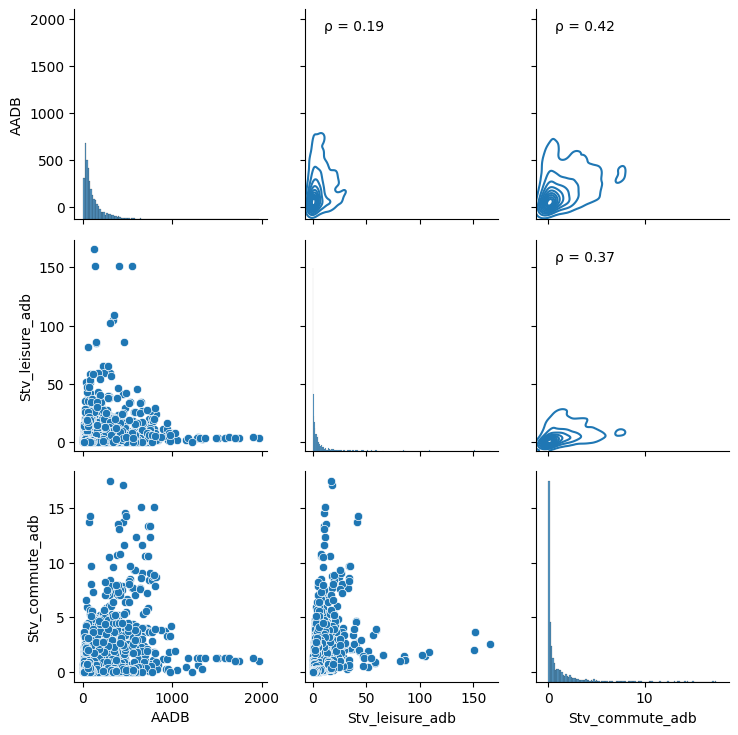

In [43]:
pretty_pair_plot(count_data[['AADB', 'Stv_leisure_adb', 'Stv_commute_adb']])

Question: what does "Forward" and "Reverse" mean in the context of the count segments we're looking at?

This is a little curious - the locations we have that are high AADB seem to have low Strava rates for both leisure and commute. Let's check these sites out:

In [44]:
count_data.query("AADB > 1000")[['street_name', 'county', 'AADB', 'Stv_leisure_adb', 'Stv_commute_adb']].sort_values("AADB", ascending=False)

street_name           county  AADB  Stv_leisure_adb  \
720                5th Street             Yolo  1967         3.726027   
723                5th Street             Yolo  1900         4.136986   
724                5th Street             Yolo  1749         3.842466   
721                5th Street             Yolo  1706         3.726027   
725                5th Street             Yolo  1706         3.842466   
722                5th Street             Yolo  1631         4.136986   
718                5th Street             Yolo  1594         3.965753   
717                5th Street             Yolo  1516         3.924658   
719                5th Street             Yolo  1494         3.965753   
1643               5th Street             Yolo  1372         3.821918   
594   North Santa Rosa Street  San Luis Obispo  1332         2.945205   
714                5th Street             Yolo  1306         3.945205   
716                5th Street             Yolo  1306         3.801370   
593        Foothill Boulevard  San Luis Obispo  1287         4.123288   
715                5th Street             Yolo  1273         3.801370   
1782         Franciscan Plaza             Kern  1225         0.027397   
1642               5th Street             Yolo  1173         3.664384   
726         Russell Boulevard             Yolo  1154         2.198630   
383      North Chester Avenue             Kern  1049         2.232877   
1346              King Street       Santa Cruz  1032         8.095890   

      Stv_commute_adb  
720          1.034247  
723          1.294521  
724          0.972603  
721          1.034247  
725          0.972603  
722          1.294521  
718          1.267123  
717          1.301370  
719          1.267123  
1643         1.246575  
594          0.280822  
714          1.321918  
716          1.239726  
593          0.616438  
715          1.239726  
1782         0.000000  
1642         1.273973  
726          0.486301  
383          0.198630  
1346         1.910959

# Surrounding characteristics
Here we'll take a look at the fields describing charactersitics around the count location

In [36]:
surrounding_cols_template = ['empnum_density_{dist}', 'nearbyuniversity_{dist}', 'pctwhite_{dist}', 'pctbiketowork_{dist}',
                    'pctatleastbachelors_{dist}', 
                    'pctnoveh_{dist}', 'popdensitysqmi_{dist}', 'hshlddensitysqmi_{dist}',]

## 1/10 mile

In [37]:
surrounding_cols_t = [c.format(dist='t') for c in surrounding_cols_template]

count_data[surrounding_cols_t].isnull().sum()

KeyError: "['nearbyuniversity_t'] not in index"

In [45]:
count_data['empnum_density_t'] = count_data['empnum_density_t'].fillna(0)

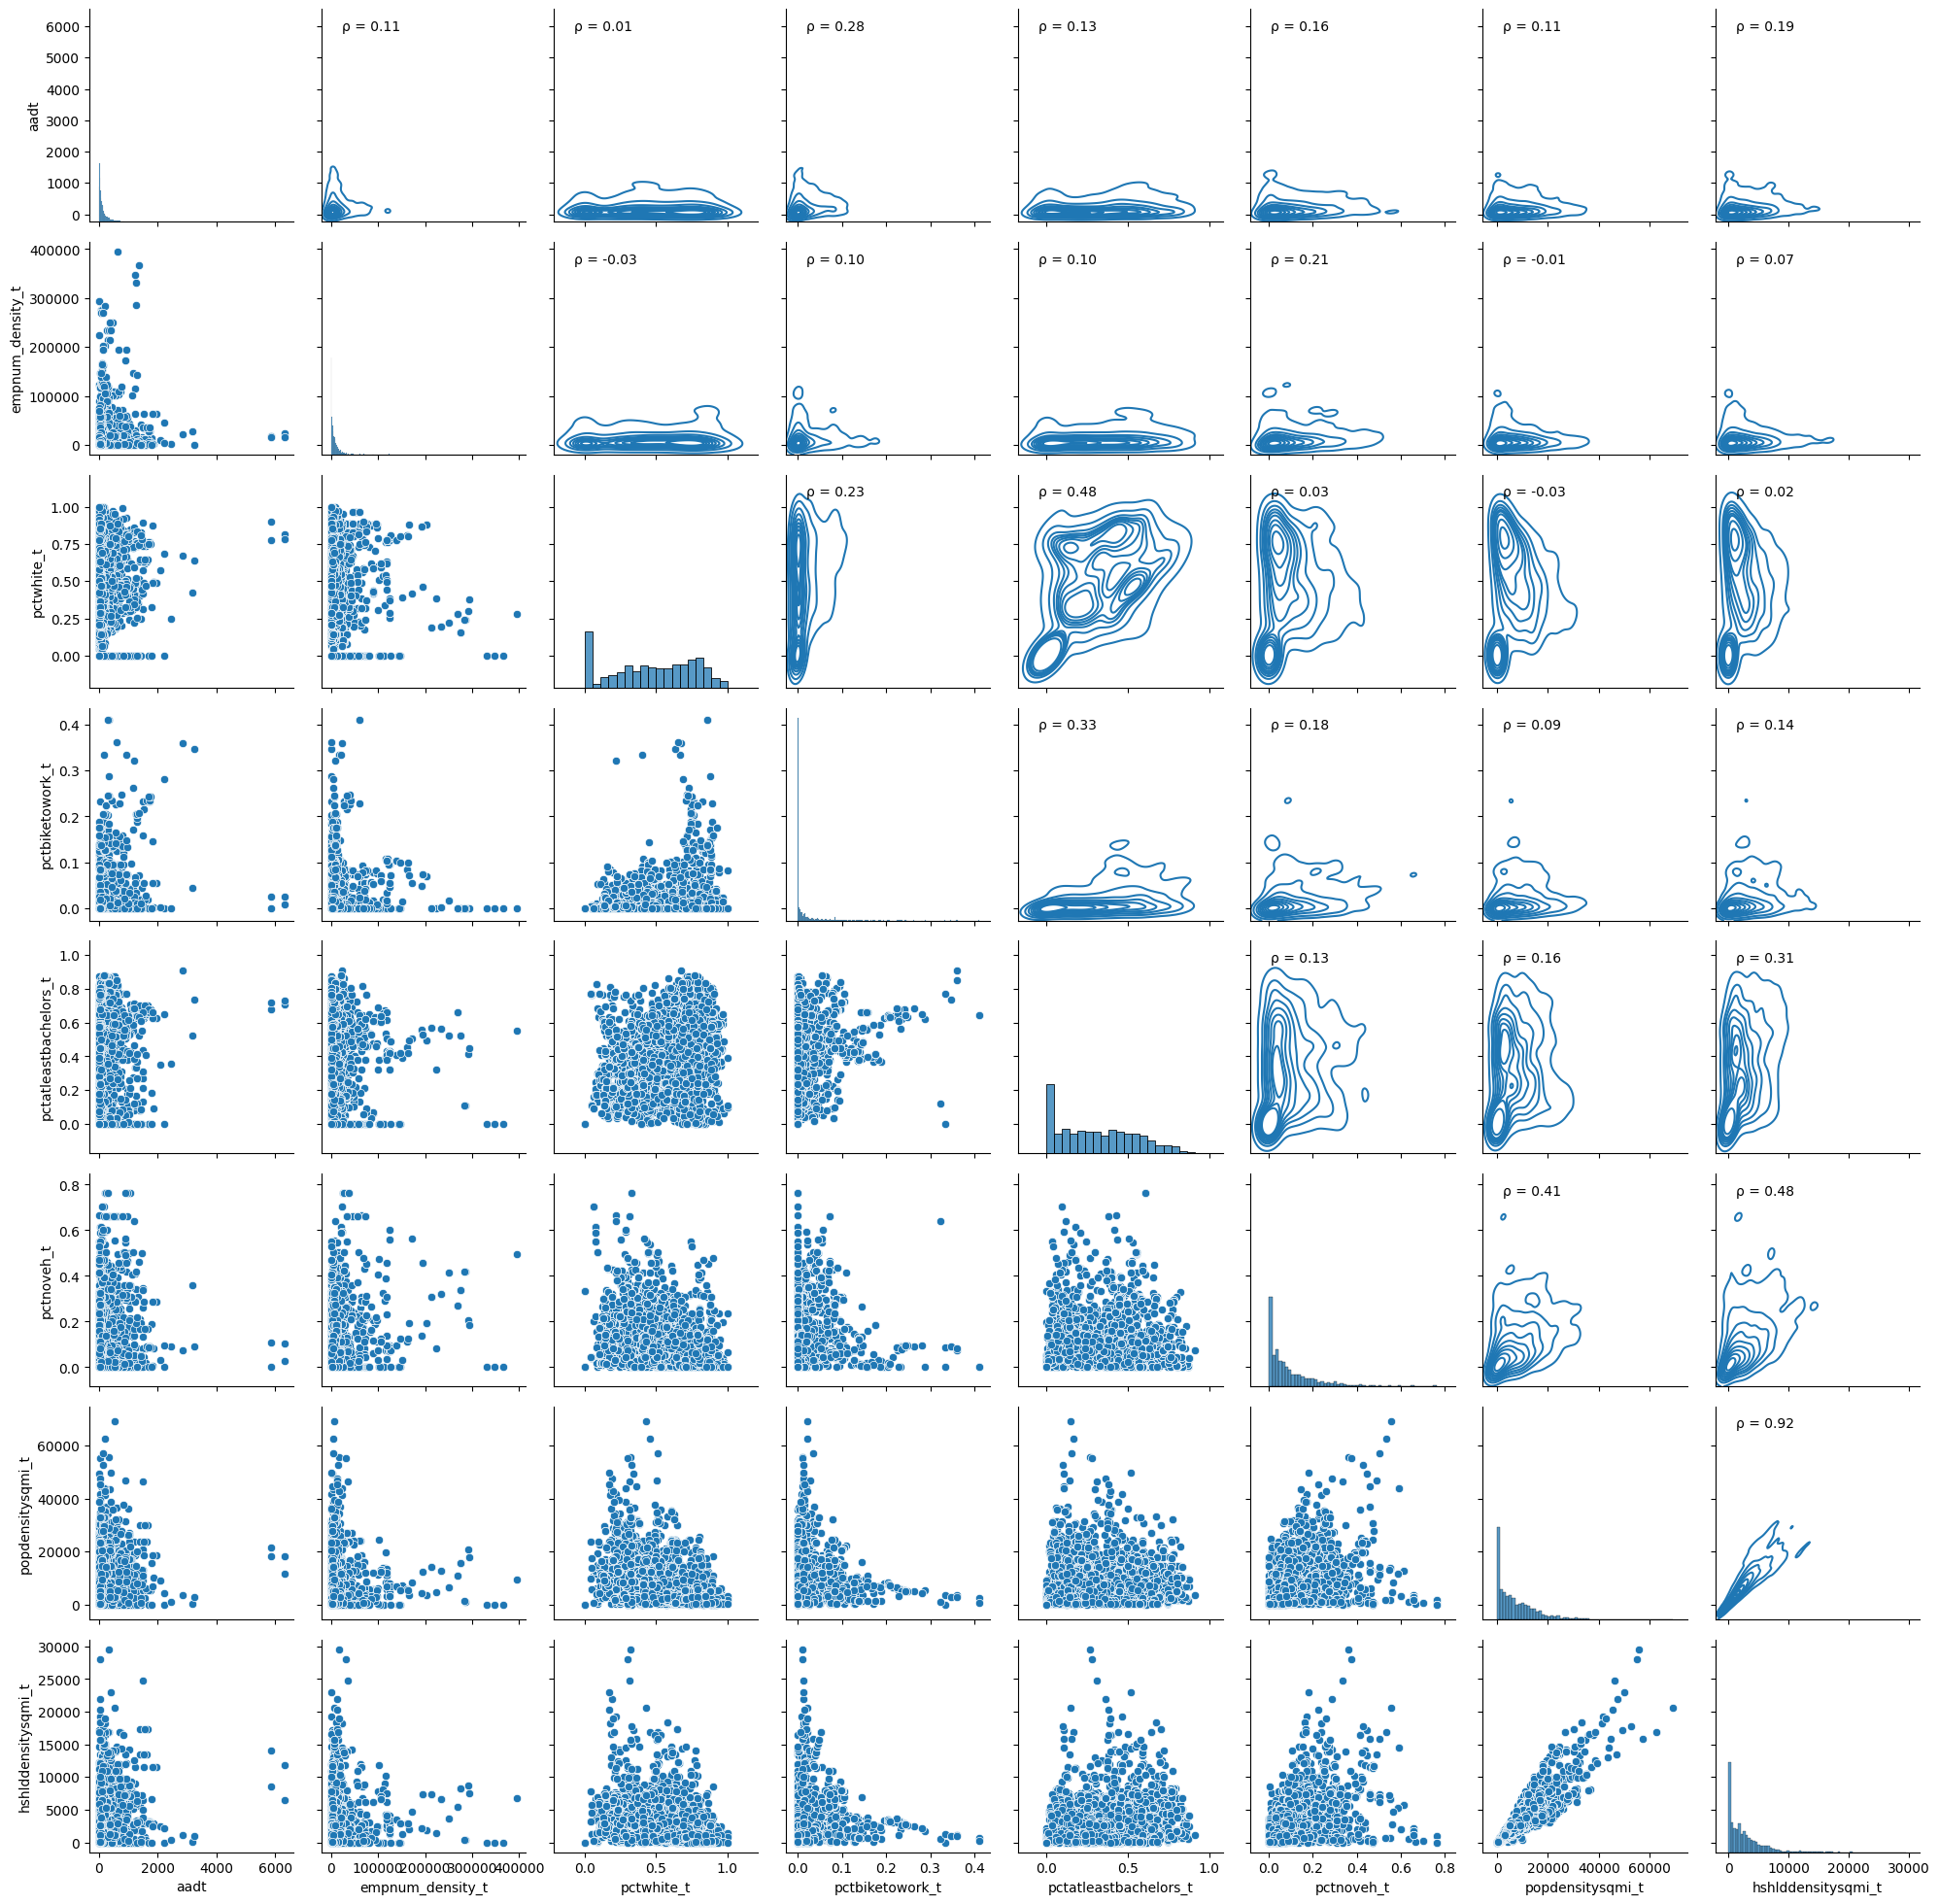

In [48]:
pretty_pair_plot(count_data[['adt'] + surrounding_cols_t])

The relationship between most of these at this scale is pretty weak.

## 1/4 mile

In [54]:
surrounding_cols_q = [c.format(dist='q') for c in surrounding_cols_template 
                     if c not in ['empnum_density_{dist}', 'nearbyuniversity_{dist}']]

count_data[surrounding_cols_q].isnull().sum()

pctwhite_q               0
pctbiketowork_q          0
pctatleastbachelors_q    0
pctnoveh_q               0
popdensitysqmi_q         0
hshlddensitysqmi_q       0
dtype: int64

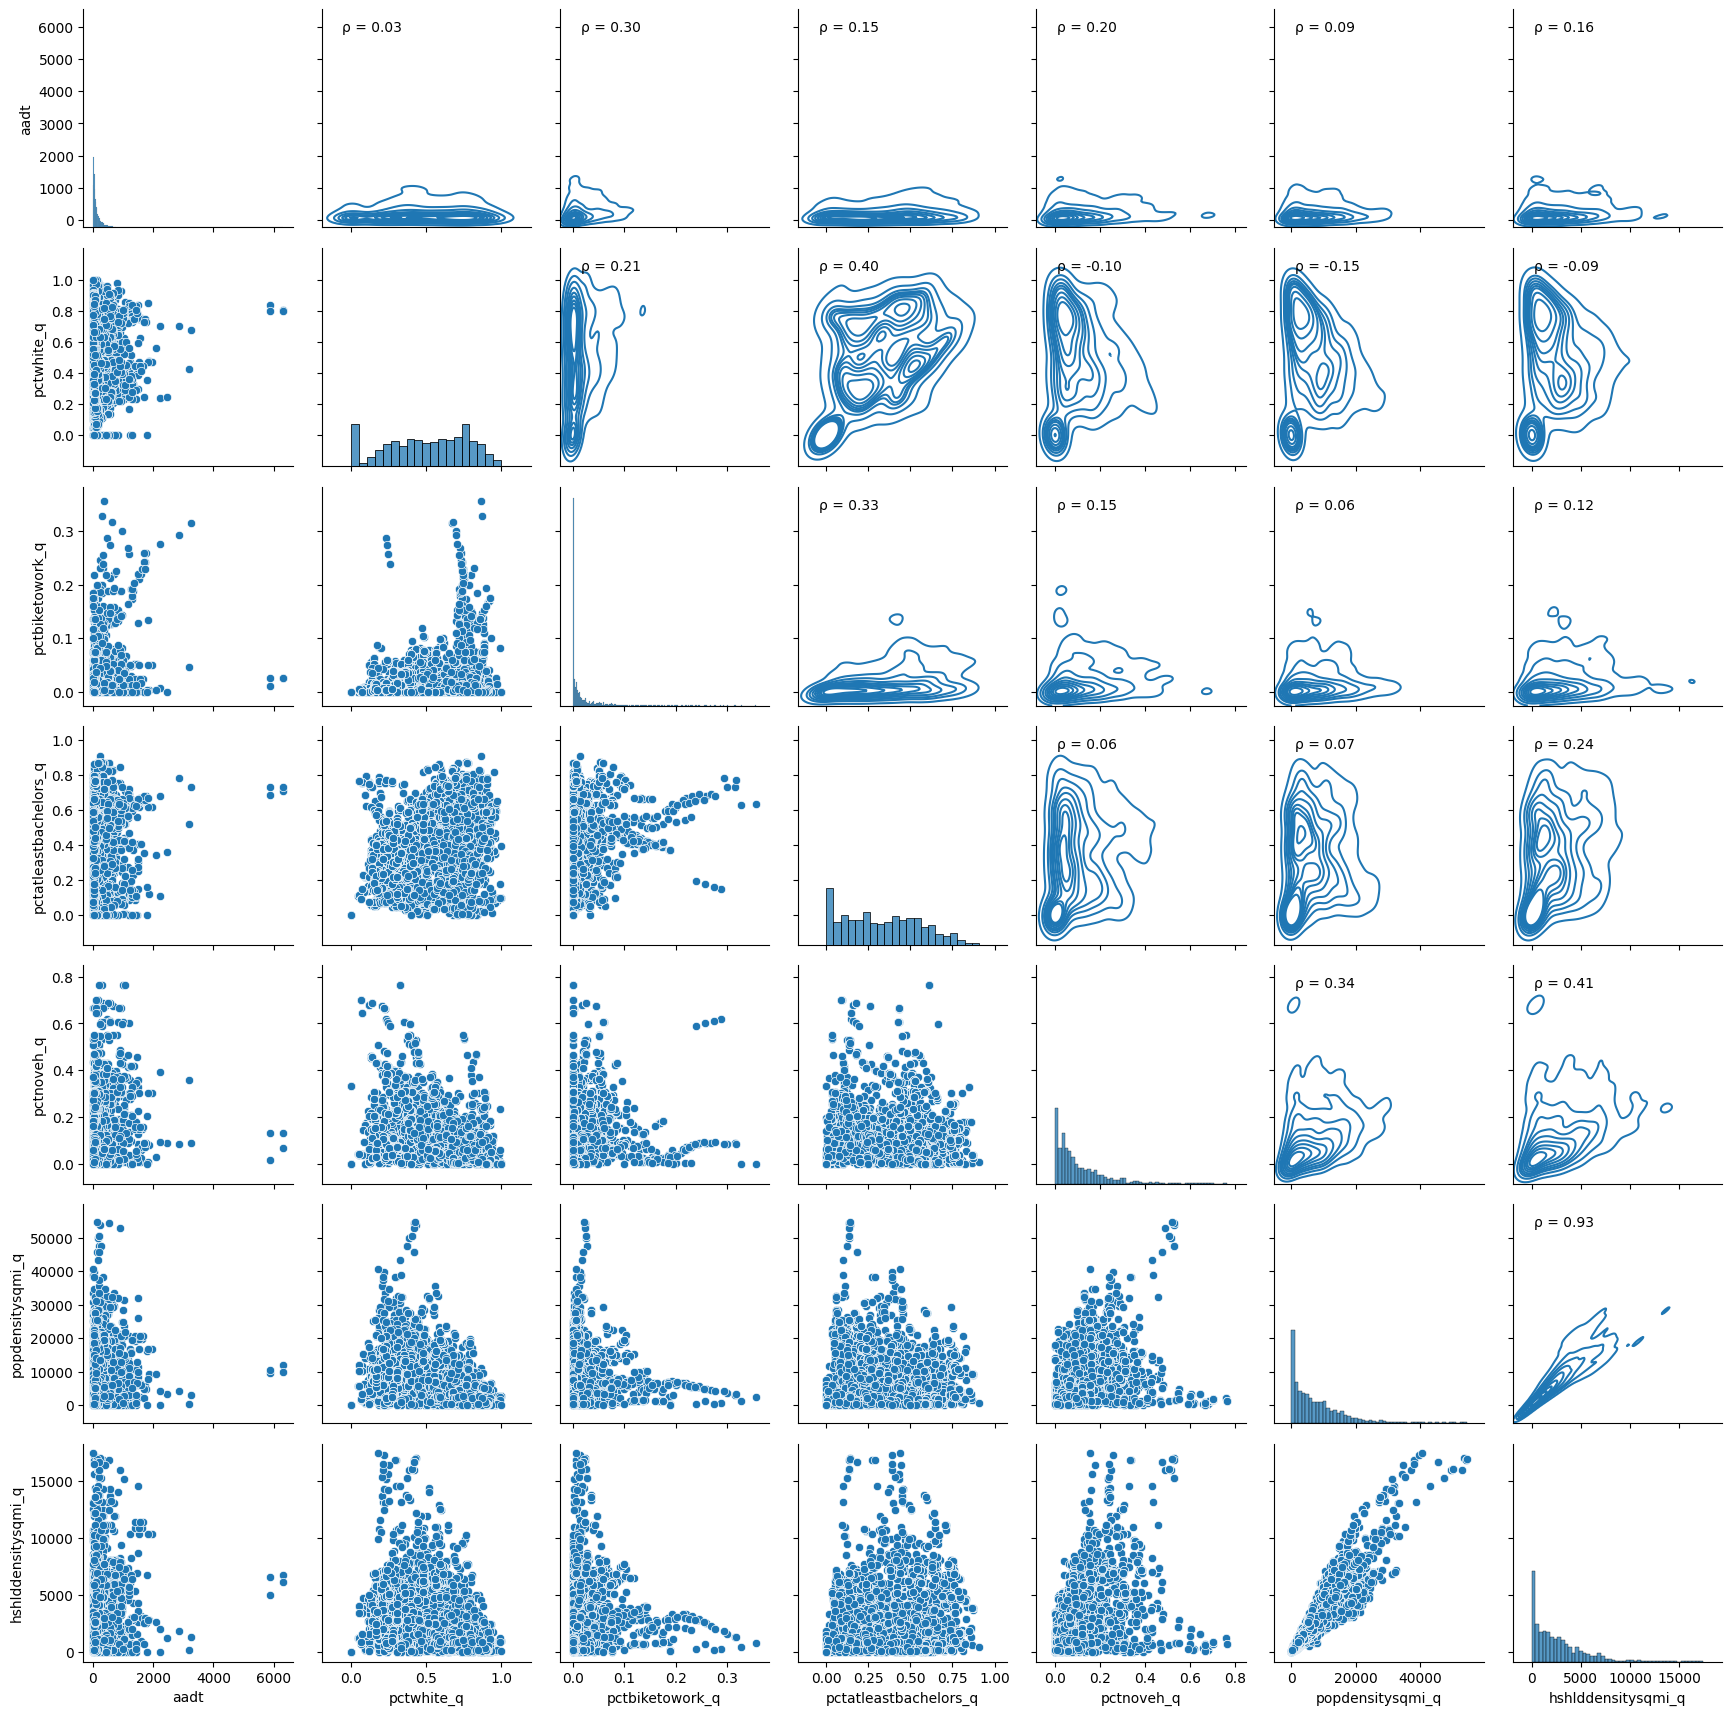

In [56]:
pretty_pair_plot(count_data[['aadt'] + surrounding_cols_q])

## 1/2 mile

In [58]:
surrounding_cols_h = [c.format(dist='h') for c in surrounding_cols_template
                     if c not in ['empnum_density_{dist}', 'nearbyuniversity_{dist}']]

count_data[surrounding_cols_h].isnull().sum()

pctwhite_h               0
pctbiketowork_h          0
pctatleastbachelors_h    0
pctnoveh_h               0
popdensitysqmi_h         0
hshlddensitysqmi_h       0
dtype: int64

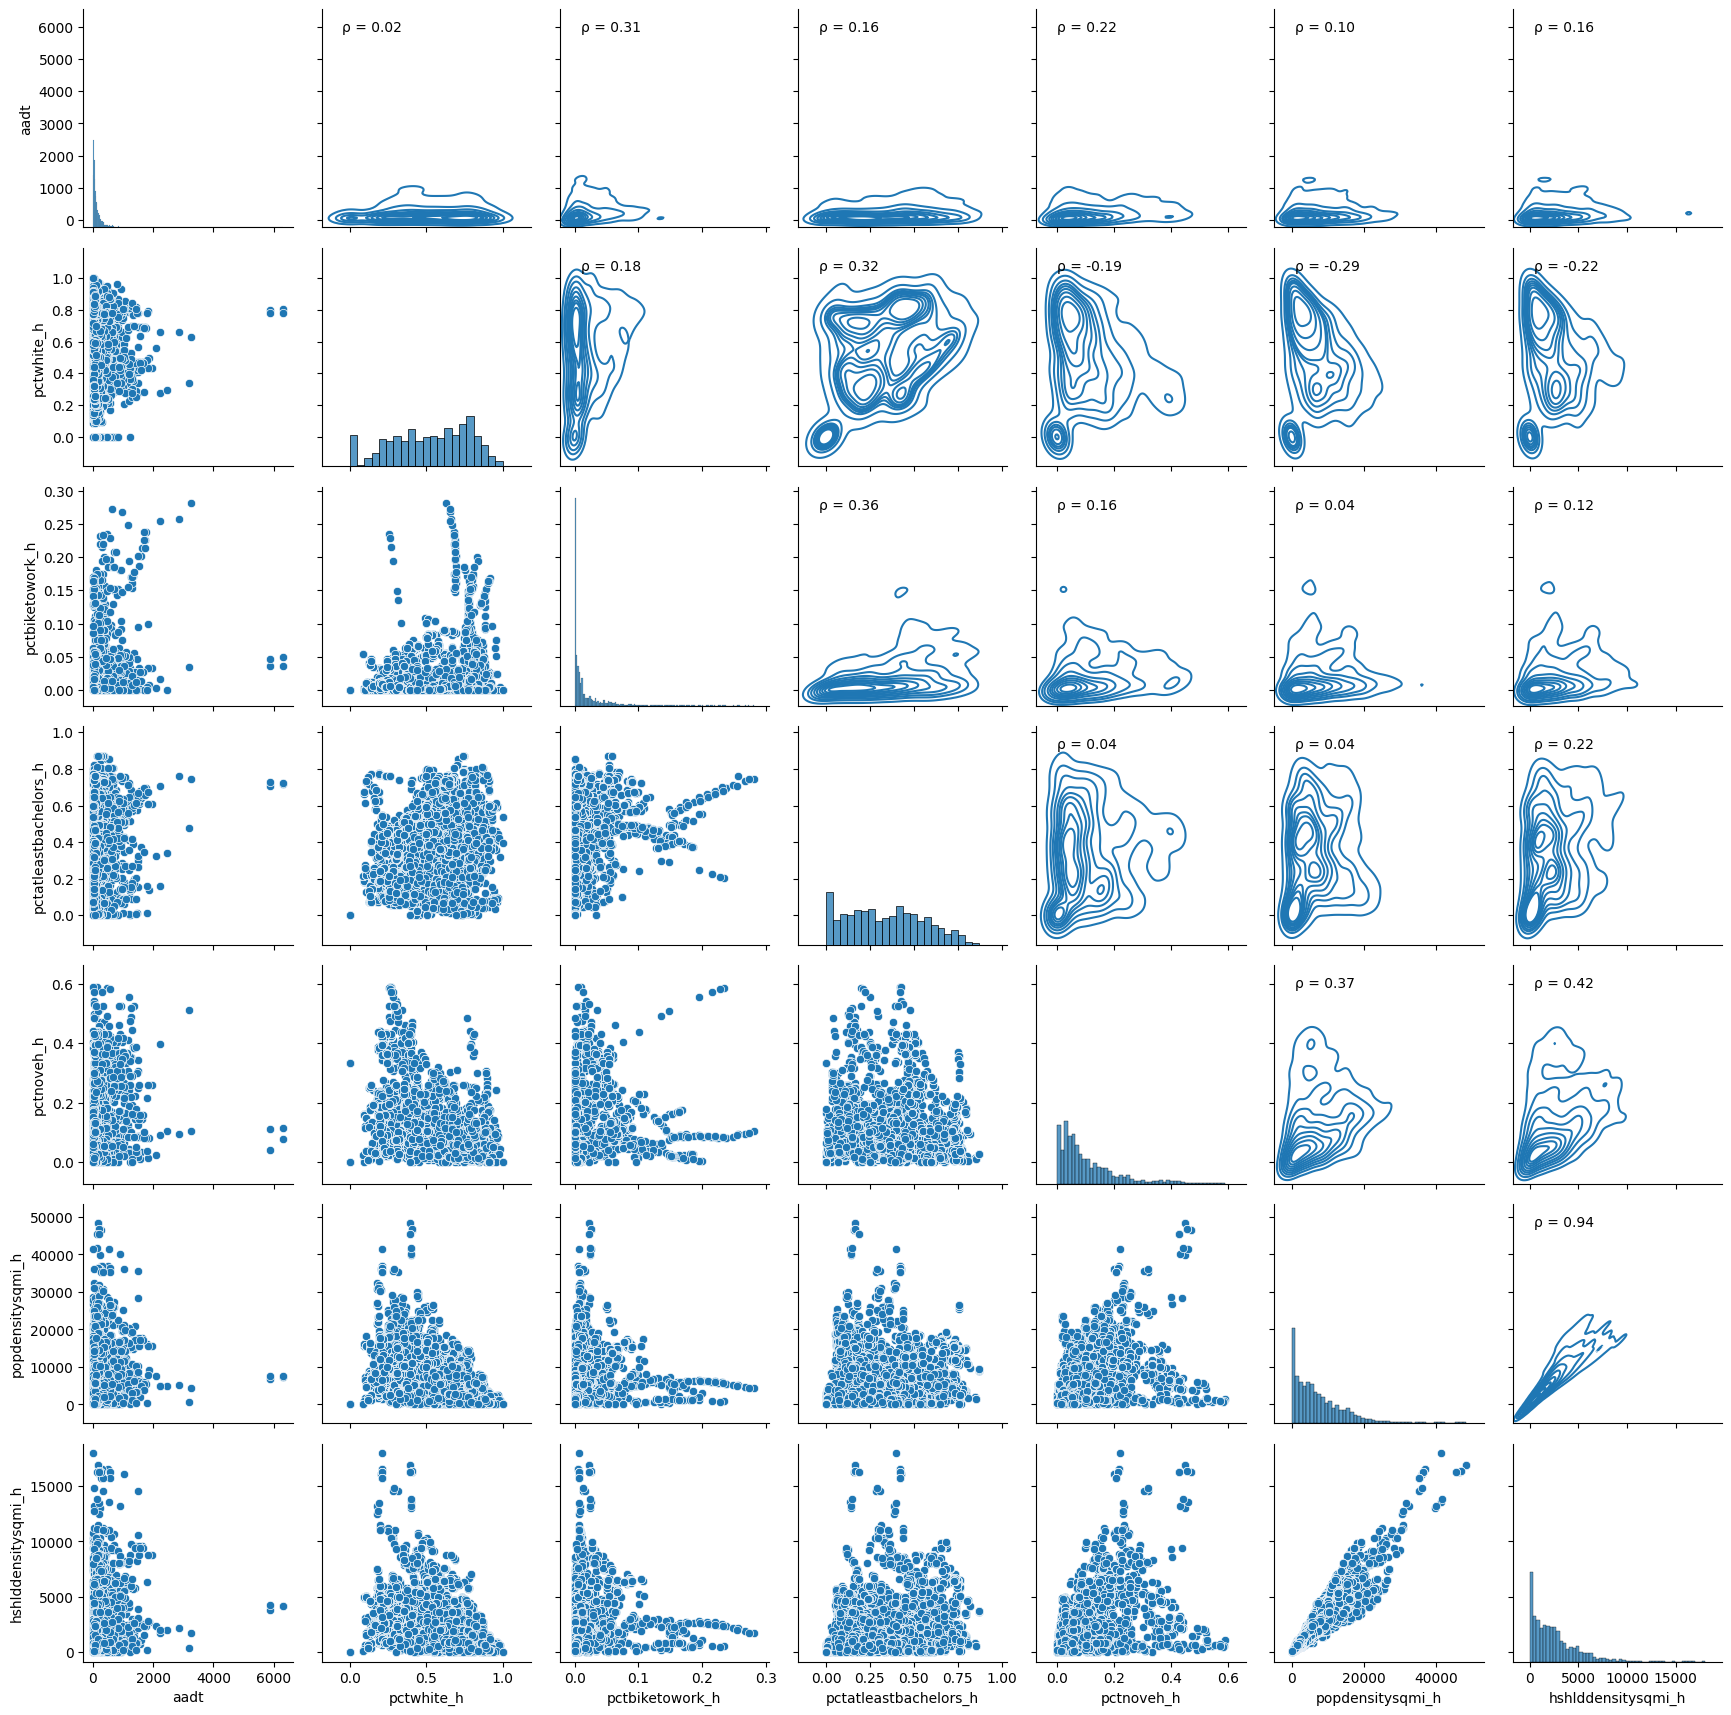

In [59]:
pretty_pair_plot(count_data[['aadt'] + surrounding_cols_h])

# Road characteristics

## Functional Class

In [78]:
count_data.fc_draft.isnull().value_counts(normalize=True)

False    1.0
Name: fc_draft, dtype: float64

<AxesSubplot:xlabel='fc_draft', ylabel='aadt'>

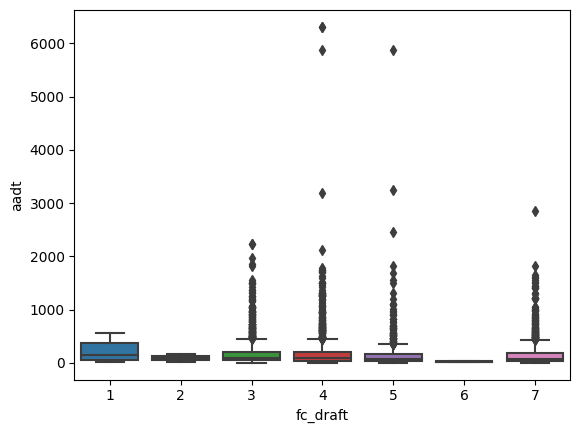

In [62]:
sns.boxplot(data=count_data, x='fc_draft', y='aadt')

<AxesSubplot:xlabel='bike_facs', ylabel='aadt'>

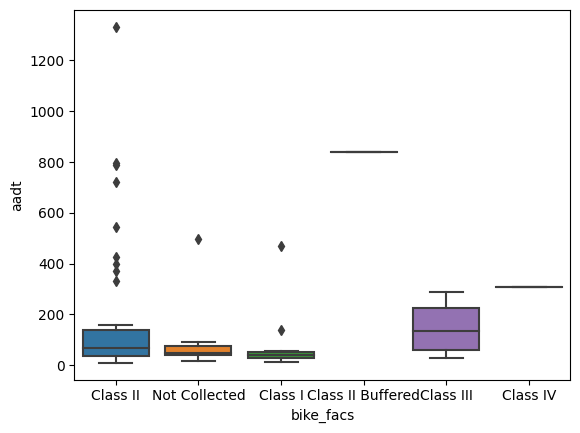

In [64]:
sns.boxplot(data=count_data, x='bike_facs', y='aadt')

In [67]:
count_data.columns[150:200]

Index(['forward_average_speed_2019_h', 'reverse_average_speed_2019_h',
       'forward_trip_count_2020_h', 'reverse_trip_count_2020_h',
       'forward_commute_trip_count_2020_h',
       'reverse_commute_trip_count_2020_h',
       'forward_leisure_trip_count_2020_h',
       'reverse_leisure_trip_count_2020_h', 'forward_average_speed_2020_h',
       'reverse_average_speed_2020_h', 'forward_trip_count_2021_h',
       'reverse_trip_count_2021_h', 'forward_commute_trip_count_2021_h',
       'reverse_commute_trip_count_2021_h',
       'forward_leisure_trip_count_2021_h',
       'reverse_leisure_trip_count_2021_h', 'forward_average_speed_2021_h',
       'reverse_average_speed_2021_h', 'geom_length', 'geom', 'access_code',
       'adt_amt', 'truck_adt_amt', 'rt_lanes_amt', 'lt_lanes_amt',
       'rt_trav_way_width', 'rt_i_shd_tot_width', 'rt_o_shd_tot_width',
       'lt_trav_way_width', 'lt_i_shd_tot_width', 'lt_o_shd_tot_width',
       'geometry', 'aadt'],
      dtype='object')

In [77]:
count_data.rt_o_shd_tot_width.isnull().value_counts(normalize=True)

True     0.954467
False    0.045533
Name: rt_o_shd_tot_width, dtype: float64

<AxesSubplot:xlabel='rt_o_shd_tot_width', ylabel='aadt'>

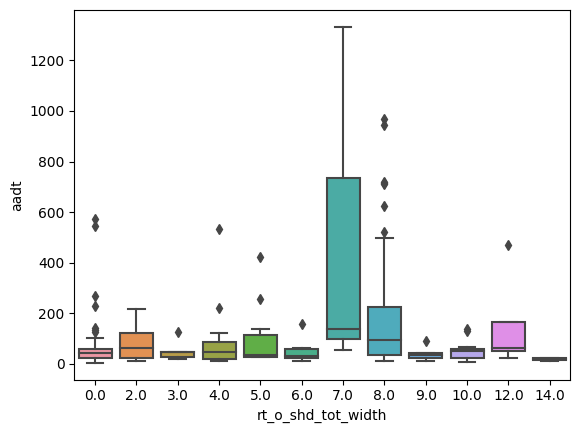

In [68]:
sns.boxplot(data=count_data, x='rt_o_shd_tot_width', y='aadt')

In [76]:
count_data.speed.isnull().value_counts(normalize=True)

False    1.0
Name: speed, dtype: float64

<AxesSubplot:xlabel='speed', ylabel='aadt'>

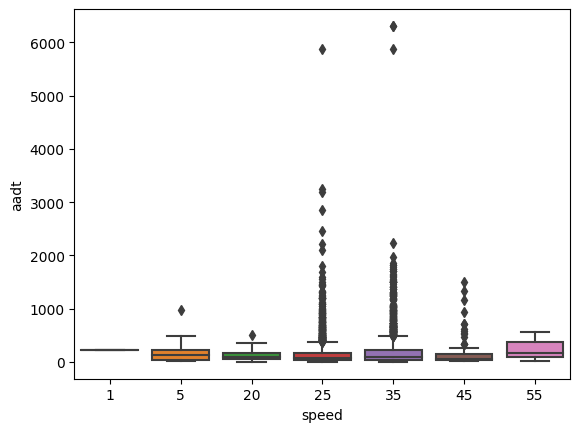

In [72]:
sns.boxplot(data=count_data, x='speed', y='aadt')

In [75]:
count_data.adt_amt.isnull().value_counts(normalize=True)

True     0.954467
False    0.045533
Name: adt_amt, dtype: float64

<AxesSubplot:xlabel='adt_amt', ylabel='aadt'>

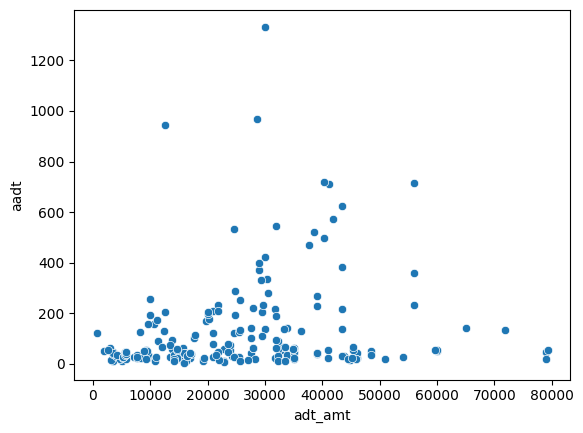

In [73]:
sns.scatterplot(data=count_data, x='adt_amt', y='aadt')

In [82]:
count_data.slope.isnull().value_counts(normalize=True)

False    1.0
Name: slope, dtype: float64

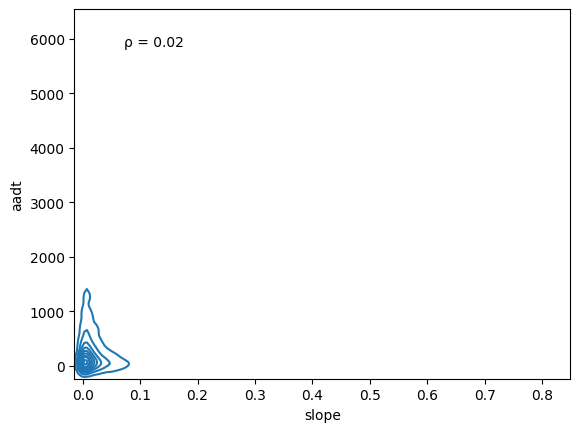

In [88]:
sns.kdeplot(data=count_data, x='slope', y='aadt')
corrfunc(count_data['slope'], count_data['aadt'])